In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import trefide.pmd

### Load 3D imaging data

Append dummy Z axis to covert to 3D data if the imaging data is of shape (x, y, time).

In [2]:
# 3D imaging data of shape (d1, d2, nchan, time)
Y = np.load('/mnt/data/3D_data/data_for_ding_apr17.npz')['Y_normalized']
Y = np.transpose(Y, [3,2,1,0])
Y = np.ascontiguousarray(Y[:56,:128,:,:])
d1, d2, nchan, T = Y.shape
print(d1, d2, nchan, T)

56 128 3 27100


In [3]:
def eval_spatial_stat(u):
    tmp1 = np.abs(u[1:,:,:] - u[:-1,:,:])
    tmp2 = np.abs(u[:,1:,:] - u[:,:-1,:])
    tmp3 = np.abs(u[:,:,1:] - u[:,:,:-1])
    return (((np.sum(tmp1) + np.sum(tmp2) + np.sum(tmp3)) * np.prod(u.shape)) / 
            ((np.prod(tmp1.shape) + np.prod(tmp2.shape) + np.prod(tmp3.shape)) * np.sum(np.abs(u)))) 

def eval_temporal_stat(v):
    return np.sum(np.abs(v[:-2] + v[2:] - 2*v[1:-1])) / np.sum(np.abs(v))

In [4]:
# Specify Decomp Parameters
bheight = 14
bwidth = 16
hbheight = int(bheight/2)
hbwidth = int(bwidth/2)

# Specify Simulation Params
T = min(6000, T)
num_blocks = 16
num_comps = 3
num_samples = 240
num_repeats = int(num_samples / (num_blocks * num_comps))

# Iteratively Simulate & Fit Noise To Collect Samples
spatial_stats = []
temporal_stats = []
for rep in range(num_repeats):    
    # Generate Noise Movie Of NumSimul Blocks
    Y_sim = np.reshape(np.random.randn(num_blocks*bwidth*bheight*nchan*T),
                       (bheight, num_blocks*bwidth, nchan, T))

    # Run Denoiser W/ Max Comp 3 and absurdly large thresholds
    out = trefide.pmd.batch_decompose(bheight, num_blocks*bwidth, nchan, T,
                                      Y_sim, bheight, bwidth,
                                      1e5, 1e5, 
                                      num_comps, 3, 10, 40, 5e-3)
    
    # Collect Test Statistics On All Samples
    for bdx in range(num_blocks):
        for cdx in range(num_comps):
            spatial_stats.append(eval_spatial_stat(out[0][bdx,cdx]))
            temporal_stats.append(eval_temporal_stat(out[1][bdx,cdx]))

spatial_stats = np.array(spatial_stats)
temporal_stats = np.array(temporal_stats)

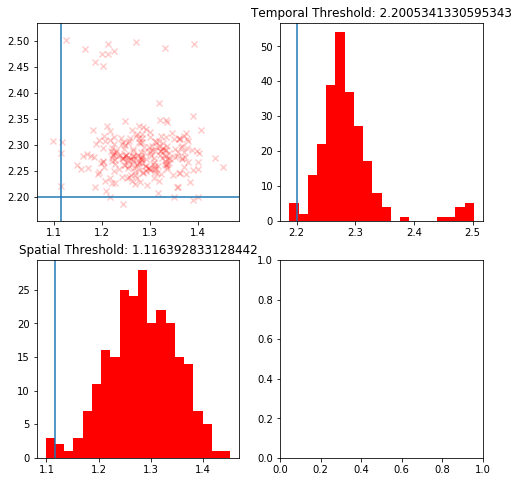

In [5]:
conf = .95
# Compute Thresholds
spatial_thresh =  np.percentile(spatial_stats, conf)
temporal_thresh = np.percentile(temporal_stats, conf)

fig, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].scatter(spatial_stats, temporal_stats, marker='x', c='r', alpha = .2)
ax[0,0].axvline(spatial_thresh)
ax[0,0].axhline(temporal_thresh)
ax[0,1].hist(temporal_stats, bins=20, color='r')
ax[0,1].axvline(temporal_thresh)
ax[0,1].set_title("Temporal Threshold: {}".format(temporal_thresh))
ax[1,0].hist(spatial_stats, bins=20, color='r')
ax[1,0].axvline(spatial_thresh)
ax[1,0].set_title("Spatial Threshold: {}".format(spatial_thresh))
plt.show()

In [6]:
max_comp = 30
temporal_thresh = 2.0

In [7]:
def overlapping_batch_decompose(d1, d2, nchan, T,
                                Y, bheight, bwidth,
                                spatial_thresh, temporal_thresh,
                                max_comp, 
                                consec_failures,
                                max_iters_main, max_iters_init,
                                tol):
    outs = []
    hbheight = int(bheight/2)
    hbwidth = int(bwidth/2)

    #Run Once On OG
    outs.append(trefide.pmd.batch_decompose(d1, d2, nchan, T,
                                            Y, bheight, bwidth,
                                            spatial_thresh, temporal_thresh,
                                            max_comp, 
                                            consec_failures,
                                            max_iters_main, max_iters_init,
                                            tol))

    #Run again on vertical offset
    Y_tmp = np.ascontiguousarray(Y[hbheight:-hbheight,:,:,:])
    outs.append(trefide.pmd.batch_decompose(d1-bheight, d2, nchan, T,
                                            Y_tmp, bheight, bwidth,
                                            spatial_thresh, temporal_thresh, 
                                            max_comp,
                                            consec_failures,
                                            max_iters_main, max_iters_init,
                                            tol))

    #Run again on horizontal offset
    Y_tmp = np.ascontiguousarray(Y[:,hbwidth:-hbwidth,:,:])
    outs.append(trefide.pmd.batch_decompose(d1, d2-bwidth, nchan, T,
                                            Y_tmp, bheight, bwidth,
                                            spatial_thresh, temporal_thresh, 
                                            max_comp,
                                            consec_failures,
                                            max_iters_main, max_iters_init,
                                            tol))

    # Run again on diagonal offset
    Y_tmp = np.ascontiguousarray(Y[hbheight:-hbheight,hbwidth:-hbwidth,:,:])
    outs.append(trefide.pmd.batch_decompose(d1-bheight, d2-bwidth, nchan, T,
                                            Y_tmp, bheight, bwidth,
                                            spatial_thresh, temporal_thresh, 
                                            max_comp,
                                            consec_failures,
                                            max_iters_main, max_iters_init,
                                            tol))
    
    return outs

In [8]:
outs = overlapping_batch_decompose(d1, d2, nchan, T,
                                   Y, bheight, bwidth,
                                   spatial_thresh, temporal_thresh,
                                   max_comp, 3, 40, 40, 5e-3)

In [9]:
def batch_recompose(denoiser_outputs, weights=None):
    
    #Preallocate
    bheight, bwidth, nchan = denoiser_outputs[0].shape[1:4]
    T = denoiser_outputs[1].shape[-1]
    nbh, nbw = np.max(denoiser_outputs[-1], axis=0)
    Y_den = np.zeros((int(nbh+1)*bheight, int(nbw+1)*bwidth, nchan, T))
    if weights is None:
        weights = np.ones((bheight,bwidth))
        
    # Accumulate Scaled Blocks
    for bdx, (rank, block_inds) in enumerate(zip(denoiser_outputs[2],
                                                 denoiser_outputs[3])):
        rank = int(rank)
        ydx = int(bheight * block_inds[0])
        xdx = int(bwidth * block_inds[1])               
        Y_den[ydx:ydx+bheight,xdx:xdx+bwidth,:,:] = np.dot(
            denoiser_outputs[0][bdx,:,:,:,:rank] * weights[:,:,None,None],
            denoiser_outputs[1][bdx,:rank,:])
    return Y_den

In [10]:
def overlapping_batch_recompose(outs, d1, d2, bheight, bwidth):
    
    hbheight = int(bheight/2)
    hbwidth = int(bwidth/2)
    
    # Generate Single Quadrant Weights
    ul_weights = np.empty((hbheight, hbwidth), dtype=np.float64)
    for i in range(hbheight):
        for j in range(hbwidth):
            ul_weights[i,j] = min(i, j)+1

    # Construct Full Tile Weights From Quadrant
    tile_weights = np.hstack([np.vstack([ul_weights, 
                                         np.flipud(ul_weights)]),
                              np.vstack([np.fliplr(ul_weights), 
                                         np.fliplr(np.flipud(ul_weights))])]) 

    # Construct Full FOV Weights By Repeating
    weights = np.tile(tile_weights, (int(d1/bheight), int(d2/bwidth)))

    # Sum All Weights At Get FOV Pixelwise-Normalization
    cumulative_weights = np.zeros((d1,d2))
    cumulative_weights += weights
    cumulative_weights[hbheight:-hbheight,:] += weights[:-bheight, :]
    cumulative_weights[:,hbwidth:-hbwidth] += weights[:, :-bwidth]
    cumulative_weights[hbheight:-hbheight,hbwidth:-hbwidth] += weights[:-bheight, :-bwidth]

    # Compose Original Tiling
    Y_den = batch_recompose(outs[0], weights=tile_weights)
    # Add Horizontal Offset
    Y_tmp = batch_recompose(outs[1], weights=tile_weights)
    Y_den[hbheight:-hbheight,:,:,:] += Y_tmp
    # Add Vertical Offset
    Y_tmp = batch_recompose(outs[2], weights=tile_weights)
    Y_den[:,hbwidth:-hbwidth,:,:] += Y_tmp
    # Add Diagonal Offset
    Y_tmp = batch_recompose(outs[3], weights=tile_weights)
    Y_den[hbheight:-hbheight,hbwidth:-hbwidth,:,:] += Y_tmp

    # Normalize Movie With recombination weights
    Y_den /= cumulative_weights[:,:,None,None]
    
    return Y_den

In [11]:
Y_den = overlapping_batch_recompose(outs, d1, d2, bheight, bwidth)
print(Y_den.shape)

(56, 128, 3, 6000)


In [12]:
def play_3d(movie, 
            gain=3, 
            fr=60, 
            offset=0, 
            magnification=1, 
            repeat=False):
    
    """ Render Video With OpenCV3 Library's Imshow"""
    d1, d2, nchan, T = movie.shape
    maxmov = np.max(movie)
    looping=True
    terminated=False
    while looping:
        for t in range(T):
            if magnification != 1:
                frame = cv2.resize(np.reshape(movie[:,:,:,t], (d1, -1), order='F'),
                                   None,
                                   fx=magnification,
                                   fy=magnification,
                                   interpolation=cv2.INTER_LINEAR)
            else:
                frame = np.reshape(movie[:,:,:,t], (d1, -1), order='F')
            cv2.imshow('frame', (frame - offset) / maxmov*gain)
            if cv2.waitKey(int(1. / fr * 1000)) & 0xFF == ord('q'):
                looping = False
                terminated = True
                break
        if terminated:
            break
        looping=repeat

    cv2.waitKey(100)
    cv2.destroyAllWindows()
    for i in range(10):
        cv2.waitKey(100)

In [13]:
# display denoised imaging data
Y_denf = np.asfortranarray(Y_den)
play_3d(Y_denf, magnification=3, gain=1)

In [14]:
# display original imaging data
Y_f = np.asfortranarray(Y)
play_3d(Y_f, magnification=3)

In [15]:
# display background noise
Y_r = np.asfortranarray(Y_f[:,:,:,:T] - Y_denf)
play_3d(Y_r, magnification=3)

In [16]:
print(np.max(Y_r), np.min(Y_r))

15.531514968545501 -9.645262929041495


In [17]:
# display original, denoised, background noise imaging data for comparison
tmp = np.vstack([Y_f[:,:,:,:T], Y_denf, Y_r])
print(tmp.shape)
play_3d(tmp, magnification=3)

(168, 128, 3, 6000)


In [18]:
np.savez("./data_for_ding_apr17_denoised_notv.npz", Y_denoised=Y_denf, Y_original=Y_f)